# OSP date extraction
---
We looked for dates in the full set of **~1.2M** documents in the corpus:

In [4]:
from osp.corpus.models.document import Document
doc_count = Document.select().count()
print(doc_count)

1177109


## Internet Archive URL timestamps

The first (and simplest) date extraction method we tried here was to just to pull out the timestamps from the Internet Archive URLs that record the date that the document was added to the archive. For example, if a syllabus was scraped from the Internet Archive, the URL will look like this:

`https://web.archive.org/web/20150102030405/http://yale.edu/syllabus.html`

We just pick out the timestamp (`20150102030405`) and parse the date. Obviously, this is an imperfect approach, since there will always be at least some lag between when the syllabus was created and when it was added to the archive. But, since there are a number of syllabi that have dates both from this method and at least one of the more accurate methods, we can get a sense of the average length of this lag time.

We got **~850k** dates from these timestamps, or **72%** of the corpus:

In [15]:
from osp.dates.models.archive_url import Document_Date_Archive_Url
archive_url_count = Document_Date_Archive_Url.select().count()

print(archive_url_count)
print((archive_url_count / doc_count) * 100)

844750
71.76480682757501


Here's the distribution:

In [13]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.dates import YearLocator, DateFormatter, date2num, epoch2num
from datetime import datetime

color = '#0067a2'

def date_histogram(dates, year1=1995, year2=2015):

    """
    Print a histogram of dates.

    Args:
        dates (list): A list of epoch2num dates.
    """

    hist_range = (
        date2num(datetime(year1, 1, 1)),
        date2num(datetime(year2, 1, 1))
    )

    (hist, edges) = np.histogram(dates, 40, range=hist_range)
    width = edges[1] - edges[0]

    fig = plt.figure(figsize=(14, 5))

    # X-axis scaling.
    ax = fig.add_subplot(111)
    ax.bar(edges[:-1], hist, width=width, color=color)
    ax.set_xlim(hist_range[0], hist_range[1])

    # X-axis formatting.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))

    plt.show()

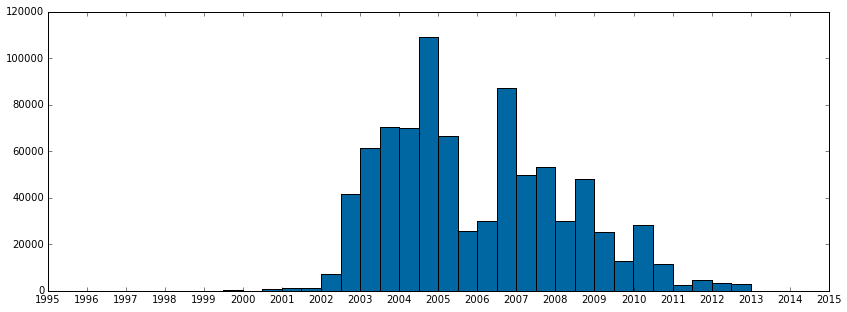

In [16]:
archive_url_dates = [epoch2num(row.date.timestamp()) for row in Document_Date_Archive_Url.select()]
date_histogram(archive_url_dates)

## PDF and DOC file metadata

Next, for PDF and DOC files, we just read out the "created" dates in the file metadata. This produced **~350k** dates from PDF and DOC file metadata creation dates, or **31%** of the corpus:

In [18]:
from osp.dates.models.file_metadata import Document_Date_File_Metadata
file_metadata_count = Document_Date_File_Metadata.select().count()

print(file_metadata_count)
print((file_metadata_count / doc_count) * 100)

364509
30.966461049911263


And, the distribution:

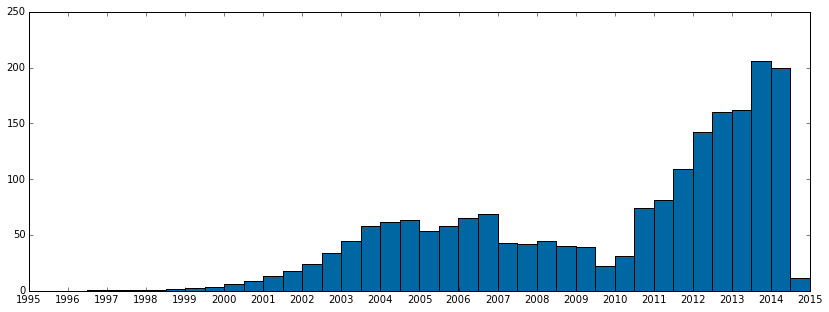

In [7]:
file_metadata_dates = [epoch2num(row.date.timestamp()) for row in Document_Date_File_Metadata.select() if row.date.year != 1901]
date_histogram(file_metadata_dates)

## Semster regular expressions

Last, we tried to find patterns in the full text of the documents that looked like "semester" markers. We looked for  a number of different variants:

- `Fall 2012`
- `Spring 2012`
- `Spring, 2012`
- `Fall 12`
- `Spring '12`

And ignored years before 1980 or in the future (see the full test suite for the job [here](https://github.com/overview/osp/blob/develop/osp/test/dates/jobs/test_ext_semester.py#L41-131)). This produced **~550k** dates, or **46%** of the corpus:

In [5]:
from osp.dates.models.semester import Document_Date_Semester
semester_count = Document_Date_Semester.select().count()

print(semester_count)
print((semester_count / doc_count) * 100)

546300
46.41031544232522


The distribution:

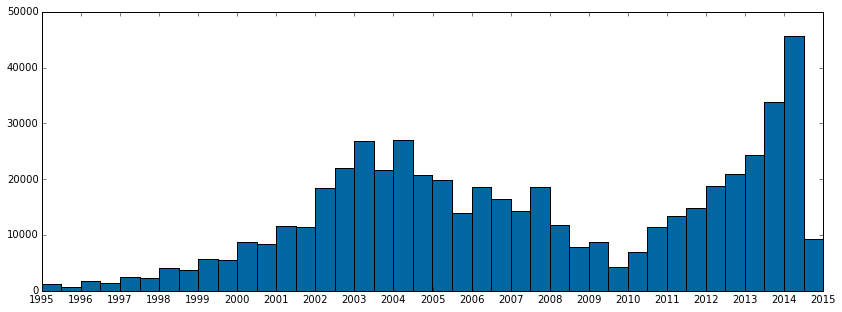

In [12]:
semester_dates = [epoch2num(row.date.timestamp()) for row in Document_Date_Semester.select()]
date_histogram(semester_dates)

##  Combined date coverage

To get the total number of documents with a date from at least one of the three methods, we can just take the union of the document ids. This gives **1,138,774** unique documents, or just shy of **~97%** of the corpus:

In [19]:
# For each method, get the set of ids for the syllabi that were matched.
archive_url_ids = [row._data['document'] for row in Document_Date_Archive_Url.select()]
file_metadata_ids = [row._data['document'] for row in Document_Date_File_Metadata.select()]
semester_ids = [row._data['document'] for row in Document_Date_Semester.select()]

# Take the union of the three lists.
ids = set()
ids.update(file_metadata_ids, semester_ids)
date_count = len(ids)

print(date_count)
print((date_count / doc_count) * 100)

683999
58.10838248624384


## Accuracy

Internet Archive URLs vs. semester regexes:

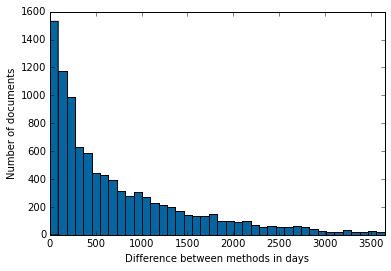

10000


In [50]:
intersection = set(archive_url_ids).intersection(semester_ids)

deltas = []
for id in list(intersection)[:10000]:
    archive_url = Document_Date_Archive_Url.get(Document_Date_Archive_Url.document==id)
    semester = Document_Date_Semester.get(Document_Date_Semester.document==id)
    delta = semester.date - archive_url.date
    deltas.append(abs(delta.days))
    
plt.hist(deltas, 40, color=color, range=(0, 3650))
plt.xlim(0, 3650)
plt.xlabel('Difference between methods in days')
plt.ylabel('Number of documents')
plt.show()

print(len(deltas))

PDF/DOCX file metadata dates vs. Internet Archive URLs:

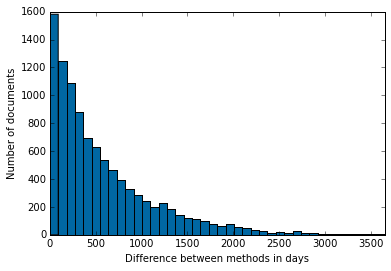

In [51]:
intersection = set(archive_url_ids).intersection(file_metadata_ids)

deltas = []
for id in list(intersection)[:10000]:
    archive_url = Document_Date_Archive_Url.get(Document_Date_Archive_Url.document==id)
    file_metadata = Document_Date_File_Metadata.get(Document_Date_File_Metadata.document==id)
    delta = archive_url.date - file_metadata.date
    deltas.append(abs(delta.days))
    
plt.hist(deltas, 40, color=color, range=(0, 3650))
plt.xlim(0, 3650)
plt.xlabel('Difference between methods in days')
plt.ylabel('Number of documents')
plt.show()

Semester regexes vs. file metadata:

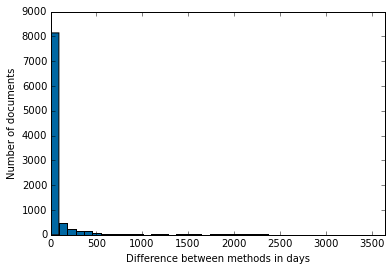

In [52]:
intersection = set(semester_ids).intersection(file_metadata_ids)

deltas = []
for id in list(intersection)[:10000]:
    semester = Document_Date_Semester.get(Document_Date_Semester.document==id)
    file_metadata = Document_Date_File_Metadata.get(Document_Date_File_Metadata.document==id)
    delta = semester.date - file_metadata.date
    deltas.append(abs(delta.days))
    
plt.hist(deltas, 40, color=color, range=(0, 3650))
plt.xlim(0, 3650)
plt.xlabel('Difference between methods in days')
plt.ylabel('Number of documents')
plt.show()